In [9]:
import os
from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Neo4jVector
from langchain.chat_models import ChatOpenAI
import networkx as nx
import matplotlib.pyplot as plt
from langchain.schema import HumanMessage


In [2]:
load_dotenv()

# Verificar se a chave está disponível
print("API Key disponível:", os.getenv("OPENAI_API_KEY") is not None)

API Key disponível: True


In [4]:
# 1. Ler o arquivo
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

text = read_file('/Users/mmoraes/Documents/Projects/RAG/graph_rag/data/black_hole.txt')

# 2. Dividir o texto em chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_text(text)

In [5]:
# 3. Criar um grafo simples usando networkx (para visualização)
G = nx.Graph()

In [6]:
llm = ChatOpenAI(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    model_name="gpt-4o"  
)

/var/folders/2j/4bp3mpqn673cqywvjyhff8_w0000gq/T/ipykernel_90001/2033286204.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


In [10]:
def extract_entities_and_relations(chunk):
    prompt = f"""
    Extraia as principais entidades e suas relações do seguinte texto sobre buracos negros:
    
    {chunk}
    
    Retorne apenas as entidades e relações no formato:
    entidade1 | relação | entidade2
    """
    
    # Usar invoke ao invés de predict
    message = HumanMessage(content=prompt)
    response = llm.invoke([message])
    return response.content

In [11]:
# 5. Processar chunks e criar grafo
for i, chunk in enumerate(chunks):
    relations = extract_entities_and_relations(chunk)
    for line in relations.split('\n'):
        if '|' in line:
            try:
                entity1, relation, entity2 = [x.strip() for x in line.split('|')]
                G.add_edge(entity1, entity2, relation=relation)
            except ValueError:
                continue  

In [12]:
# Opcional: Adicionar logging para debug
import logging
logging.basicConfig(level=logging.INFO)

In [13]:
for i, chunk in enumerate(chunks):
    logging.info(f"Processando chunk {i+1}/{len(chunks)}")
    relations = extract_entities_and_relations(chunk)
    logging.info(f"Relações encontradas:\n{relations}")
    for line in relations.split('\n'):
        if '|' in line:
            try:
                entity1, relation, entity2 = [x.strip() for x in line.split('|')]
                G.add_edge(entity1, entity2, relation=relation)
                logging.debug(f"Adicionada relação: {entity1} -{relation}-> {entity2}")
            except ValueError as e:
                logging.warning(f"Erro ao processar linha: {line}. Erro: {e}")

INFO:root:Processando chunk 1/45
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Relações encontradas:
Black hole | is a region of | spacetime  
Gravity | is so strong that | nothing can escape  
Einstein's theory of general relativity | predicts | deformation of spacetime into a black hole  
Sufficiently compact mass | can deform | spacetime  
Boundary of no escape | is called | event horizon  
Black hole | affects | object crossing it  
INFO:root:Processando chunk 2/45
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Relações encontradas:
Buraco Negro | emite | Radiação de Hawking  
Buraco Negro | atua como | Corpo Negro Ideal  
Horizonte de Eventos | tem | Temperatura  
Temperatura | é inversamente proporcional a | Massa  
Buraco Negro Estelar | tem | Temperatura na ordem de bilionésimos de Kelvin
INFO:root:Processando chunk 3/45
INFO:httpx:HTTP Request: POST https://api.openai.c

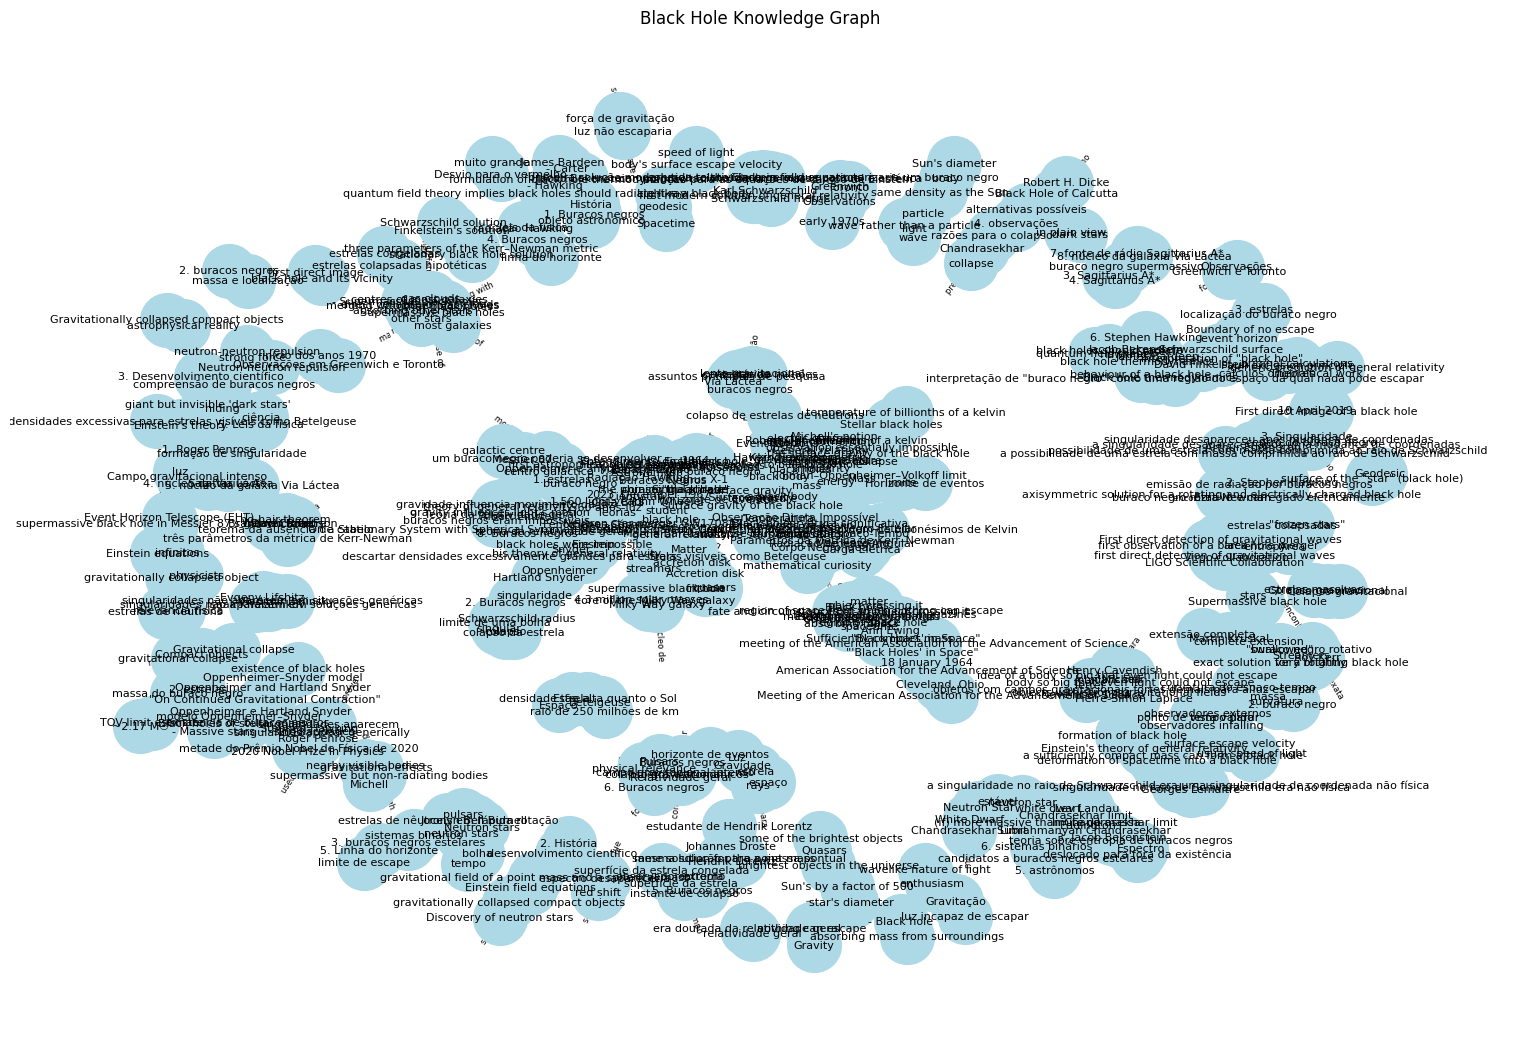

In [14]:
# 6. Visualizar o grafo
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=1500, font_size=8)

edge_labels = nx.get_edge_attributes(G, 'relation')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.title("Black Hole Knowledge Graph")
plt.savefig('black_hole_graph.png')
plt.show()

In [15]:
def query_graph(query_text):
    prompt = f"""
    Usando o conhecimento do grafo sobre buracos negros, responda:
    {query_text}
    """
    response = llm.predict(prompt)
    return response

# Exemplo de uso:
print(query_graph("what is the relationship between horizon and black hole?"))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


No contexto dos buracos negros, o termo "horizonte" refere-se ao "horizonte de eventos". O horizonte de eventos é uma fronteira teórica ao redor de um buraco negro, além da qual nada pode escapar, nem mesmo a luz. É o ponto sem retorno. Em termos simples, se algo atravessa o horizonte de eventos de um buraco negro, ele será inevitavelmente puxado para dentro do buraco negro devido à sua intensa gravidade.

Portanto, a relação entre o horizonte e o buraco negro é que o horizonte de eventos é a "fronteira" ou "superfície" ao redor do buraco negro que define a região do espaço-tempo onde a gravidade do buraco negro é tão forte que nada pode escapar. Dentro desse horizonte, o destino do objeto é ser sugado para o centro do buraco negro, conhecido como singularidade.
